In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Downloading and normalizing data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170385408/170498071 [01:08<00:00, 2343830.46it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [01:20, 2343830.46it/s]                               

### On what pictures are we working

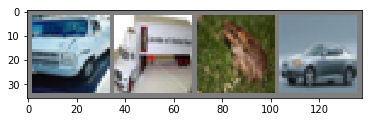

  car truck  frog   car


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
[testloader.dataset.data.shape,trainloader.dataset.data.shape]

[(10000, 32, 32, 3), (50000, 32, 32, 3)]

In [109]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

### Preparing dataset for ML

In [72]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [73]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler, num_workers=2)

#  Define a Convolutional Neural Network

In [74]:
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input channels = 3, output channels = 6
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): # 32,32,3
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Define a Loss function and optimizer

In [68]:
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

In [69]:
import torch.optim as optim
def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [75]:
import time
from torch.autograd import Variable

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    TRAIN_LOSS = []
    VALIDATION_LOSS = []
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                TRAIN_LOSS.append(running_loss / print_every)
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        VALIDATION_LOSS.append(total_val_loss / len(val_loader))   
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    print(f"TRAIN {TRAIN_LOSS}, VALIDATION {VALIDATION_LOSS}")


In [76]:
trainNet(net, batch_size=32, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 5
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.24 took: 1.24s
Epoch 1, 20% 	 train_loss: 2.08 took: 1.01s
Epoch 1, 30% 	 train_loss: 1.94 took: 1.07s
Epoch 1, 40% 	 train_loss: 1.82 took: 1.01s
Epoch 1, 50% 	 train_loss: 1.82 took: 1.03s
Epoch 1, 60% 	 train_loss: 1.73 took: 1.08s
Epoch 1, 70% 	 train_loss: 1.73 took: 1.00s
Epoch 1, 80% 	 train_loss: 1.71 took: 1.04s
Epoch 1, 90% 	 train_loss: 1.68 took: 1.10s
Validation loss = 1.57
Epoch 2, 10% 	 train_loss: 1.63 took: 1.10s
Epoch 2, 20% 	 train_loss: 1.60 took: 1.03s
Epoch 2, 30% 	 train_loss: 1.58 took: 1.04s
Epoch 2, 40% 	 train_loss: 1.55 took: 1.03s
Epoch 2, 50% 	 train_loss: 1.57 took: 1.03s
Epoch 2, 60% 	 train_loss: 1.52 took: 1.04s
Epoch 2, 70% 	 train_loss: 1.54 took: 1.04s
Epoch 2, 80% 	 train_loss: 1.52 took: 1.04s
Epoch 2, 90% 	 train_loss: 1.51 took: 1.10s
Validation loss = 1.43
Epoch 3, 10% 	 train_loss: 1.42 took: 1.13s
Epoch 3, 20% 	 train_loss: 1.43 took: 1.05s


In [80]:
train_steps = [2.2407,2.0817, 1.9399, 1.8208, 1.8206, 1.7263, 1.7255, 1.7103, 1.6751, 1.6272, 1.5985,1.5812, 1.5523, 1.5748, 1.5236, 1.5436, 1.5191, 1.5054, 1.4171, 1.4345, 1.4052,1.3978,
1.4186, 1.3930, 1.3571, 1.3781, 1.4314, 1.2968,
1.3568, 1.2939,1.3037, 1.2943, 1.2983, 1.3355, 1.3083, 1.2762, 1.2372, 1.2520, 1.2280, 1.2495, 1.2259, 1.2081, 1.2230, 1.2224, 1.2084]

In [89]:
validation_steps = [1.5685, 1.4254, 1.3626, 1.3133, 1.3125]

In [86]:
import matplotlib.pyplot as plt
np.arange(1,len(train_steps))
len(train_steps)
np.arange(11,len(train_steps)+1,10)

array([11, 21, 31, 41])

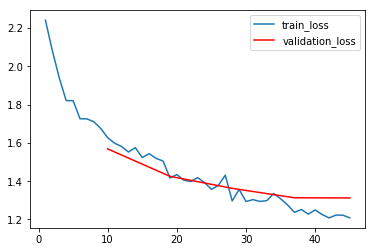

In [93]:
plt.plot(np.arange(1,len(train_steps)+1),train_steps,label = 'train_loss')
plt.plot(np.array([10,19,28,37,45]),validation_steps,color = 'red',label = 'validation_loss')
plt.legend()
plt.show()

# Test the network on the test data

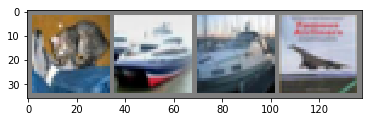

GroundTruth:    cat  ship  ship plane


In [94]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [99]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


## What is accuracy on the whole data-set ?

In [100]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [101]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 66 %
Accuracy of  bird : 34 %
Accuracy of   cat : 22 %
Accuracy of  deer : 47 %
Accuracy of   dog : 50 %
Accuracy of  frog : 53 %
Accuracy of horse : 75 %
Accuracy of  ship : 68 %
Accuracy of truck : 64 %
